In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 


train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

#train shape
print(train.shape)
#test shape
print(test.shape)

(114321, 133)
(114393, 132)


In [9]:
from sklearn.base import TransformerMixin

In [2]:
train.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


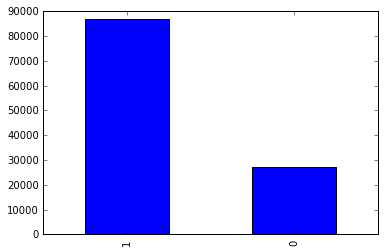

In [3]:
#target varibale 
train.target.value_counts().plot.bar()

In [6]:
#https://www.kaggle.com/chabir/bnp-paribas-cardif-claims-management/extratreesclassifier-score-0-45-v5
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble 

print('Load data...')
train = pd.read_csv("../input/train.csv")
target = train['target'].values
train = train[['v3','v10','v12','v14','v21','v22','v24','v30','v31','v34','v38','v40','v47','v50','v52','v56','v62','v66','v71','v72','v74','v75','v79','v91','v107','v110','v112','v113','v114','v125','v129']]
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values
test = test[['v3','v10','v12','v14','v21','v22','v24','v30','v31','v34','v38','v40','v47','v50','v52','v56','v62','v66','v71','v72','v74','v75','v79','v91','v107','v110','v112','v113','v114','v125','v129']]






Load data...


# Kaggle training

## Feature engineering

In [102]:
train.v30.unique()

array(['C', nan, 'G', 'D', 'B', 'F', 'A', 'E'], dtype=object)

## Filing missing values

In [10]:
class DataFrameFiller(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [11]:
X_all = train.append(test)

In [14]:
X_all.shape

(228714, 31)

In [76]:
X_all_filled = DataFrameFiller().fit_transform(X_all)

### Changing v22 with percentage

In [105]:
X_all_filled['count'] = 1
X_all_filled = X_all_filled[:len(target)]
x = X_all_filled[['v22', 'count']][target == 1]
X_all_filled.drop(['count'], axis = 1, inplace = True)
len(X_all_filled)

114321

In [114]:
x_grouped = x.groupby(['v22']).sum() / len(target)
x = x_grouped.reset_index()
X = pd.merge(X_all_filled, x, on='v22', how='outer')
X = X.fillna(0)
X.isnull().sum()

v3       0
v10      0
v12      0
v14      0
v21      0
v22      0
v24      0
v30      0
v31      0
v34      0
v38      0
v40      0
v47      0
v50      0
v52      0
v56      0
v62      0
v66      0
v71      0
v72      0
v74      0
v75      0
v79      0
v91      0
v107     0
v110     0
v112     0
v113     0
v114     0
v125     0
v129     0
count    0
dtype: int64

In [116]:
X['v22'] = X['count']
X.drop(['count'], axis = 1, inplace = True)

In [117]:
X.to_csv('prep.csv')

* Genetic programming
* Target class percentage
* Interactions
* Text features interpretations

## Algorithms

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble

* LogReg + Ridge / Lasso / Elastic
* LibFM http://libfm.org
* RGF http://stat.rutgers.edu/home/tzhang/software/rgf/
* Neural Network Keras / Lasagne / Caffe / Tensorflow
* SVM /SVMV 
* ET / RF / XGBoost hyperopt 

In [121]:
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

## 2nd level 

In [127]:
for f in X.columns:
    if X[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(X[f].values)))
        X[f] = lbl.transform(list(X[f].values))

In [128]:
X_fit, X_eval, y_fit, y_eval = train_test_split(X, target, test_size = 0.2, stratify=target, random_state=1)

* Stacking 
* Blending 
* Voting 

In [129]:
xgtrain = xgb.DMatrix(X_fit, y_fit)
xgtest = xgb.DMatrix(test)

clf = xgb.XGBClassifier(missing=np.nan, max_depth=7, 
                        n_estimators=300, learning_rate=0.05, 
                        subsample=1, colsample_bytree=0.9, seed=2100,objective= 'binary:logistic')
clf.fit(X_fit, y_fit, early_stopping_rounds=35,  eval_metric="logloss", eval_set=[(X_eval, y_eval)], verbose = 1)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2100, silent=True, subsample=1)

In [131]:
from  sklearn.metrics import log_loss
log_train = log_loss(y_fit, clf.predict_proba(X_fit)[:,1])
log_valid = log_loss(y_eval, clf.predict_proba(X_eval)[:,1])


print('\n-----------------------')
print('  logloss train: %.5f'%log_train)
print('  logloss valid: %.5f'%log_valid)
print('-----------------------')


-----------------------
  logloss train: 0.53663
  logloss valid: 0.55082
-----------------------
